In [142]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load Image and Display


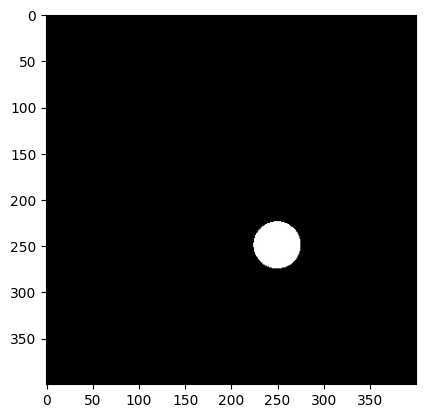

In [143]:
def load_image(path):
    return np.array(Image.open(path).convert('L'))

image_array = load_image('img/Kropka.jpg')

plt.imshow(image_array, cmap='gray')
plt.show()

# Radon Transform

- Bresenham's algorithm

In [144]:
def radon_transform(image, length, num_detectors, alpha):
    
    height, width_img = image.shape
    center = [width_img // 2, height // 2]  # Image's center
    radius = min(center)
    
    sinogram = []
    
    for angle in range(0, 360, alpha):  # zebranie probek promieni over angle on full circle
        sinogram.append([])
        
        # stożkowy model
        for detector_idx in range(num_detectors):  # loop over detectors
            emitter_x = radius * np.cos(np.radians(angle))
            emitter_y = radius * np.sin(np.radians(angle))
            detector_x = radius * np.cos(np.radians(angle + 180 - (length / 2) + detector_idx * (length / (num_detectors - 1))))
            detector_y = radius * np.sin(np.radians(angle + 180 - (length / 2) + detector_idx * (length / (num_detectors - 1))))
            
            emitter_x = int(emitter_x) + center[0]
            emitter_y = int(emitter_y) + center[1]
            detector_x = int(detector_x) + center[0]
            detector_y = int(detector_y) + center[1]
            
            ray_line = bresenham(emitter_x, emitter_y, detector_x, detector_y)
            pixel_intensity = calculate_ray_intensity(image, ray_line)
            
            sinogram[-1].append(pixel_intensity)
    
    return sinogram


def bresenham(x0, y0, x1, y1):
    line = []
    kx = 1 if x0 <= x1 else -1
    ky = 1 if y0 <= y1 else -1

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    x = x0
    y = y0
    line.append([x, y])
    if dx >= dy:
        e = dx / 2
        for i in range(0, int(dx)):
            x = x + kx
            e = e - dy
            if e < 0:
                y = y + ky
                e = e + dx
            line.append([x, y])
    else:
        e = dy / 2
        for i in range(0, int(dy)):
            y = y + ky
            e = e - dx
            if e < 0:
                x = x + kx
                e = e + dy
            line.append([x, y])
    return line

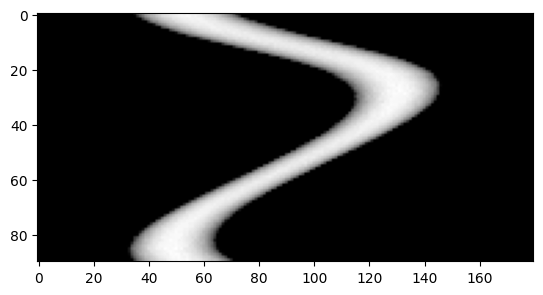

In [145]:
length=180
detector_amount=180
alpha=4

sinogram= radon_transform(image_array, length, detector_amount, alpha)
plt.imshow(sinogram, cmap='gray')

plt.show()